In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#Section 1 - Funnel Analysis



**Identify and appropriately handle the missing/blank and duplicate values in the dataset, and explain the logic behind your strategy in a short paragraph.**

In [2]:
import pandas as pd
funnel = pd.read_excel('/content/drive/MyDrive/FittLyf Assessment/AssignmentData.xlsx')
funnel.head()

,Date,Quarter,Department,Targeted Productivity,Overtime,No. of Workers,Actual Productivity
0,2015-01-01 00:00:00,Q1,Sewing,0.8,7080,59,0.940725
1,2015-01-01 00:00:00,Q1,Finishing,0.75,960,8,0.8865
2,2015-01-01 00:00:00,Q1,Sewing,0.8,3660,30.5,0.80057
3,2015-01-01 00:00:00,Q1,Sewing,0.8,3660,30.5,0.80057
4,2015-01-01 00:00:00,Q1,Sewing,0.8,1920,56,NaN


In [3]:
print(funnel.describe())
print(funnel.info())

                       Date Quarter Department  Targeted Productivity  \
count                  1197    1197       1197                 1197.0   
unique                   59       5          2                   10.0   
top     2015-11-03 00:00:00      Q1     Sewing                    0.8   
freq                     24     360        691                  539.0   

        Overtime  No. of Workers  Actual Productivity  
count       1197            1197          1168.000000  
unique       144              62           867.000000  
top          960               8             0.800402  
freq         129             262            24.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   1197 non-null   object
 1   Quarter                1197 non-null   object
 2   Department             1197 non-null   

In [4]:
funnel['Date'] = pd.to_datetime(funnel['Date'])
columns_to_convert = ['Targeted Productivity', 'Overtime', 'No. of Workers', 'Actual Productivity']
for column in columns_to_convert:
    # Converting to numeric, setting non-numeric values to NaN
    funnel[column] = pd.to_numeric(funnel[column], errors='coerce')
    # Calculating the mean of the column, ignoring NaN values
    mean_value = funnel[column].mean()
    # Replacing NaN values with the mean of the column
    funnel[column].fillna(mean_value, inplace=True)

In [5]:
# Checking for duplicates
print('Duplicates: ',funnel.duplicated().sum())
# Checking for missing values
print('Null:\n',funnel.isnull().sum())
# Dropping duplicates if any
funnel.drop_duplicates(inplace=True)
# Filling missing values in 'Actual Productivity' with mean value
funnel['Actual Productivity'].fillna(funnel['Actual Productivity'].mean(), inplace=True)

Duplicates:  35
Null:
 Date                     0
Quarter                  0
Department               0
Targeted Productivity    0
Overtime                 0
No. of Workers           0
Actual Productivity      0
dtype: int64


In [6]:
funnel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1162 entries, 0 to 1196
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1162 non-null   datetime64[ns]
 1   Quarter                1162 non-null   object        
 2   Department             1162 non-null   object        
 3   Targeted Productivity  1162 non-null   float64       
 4   Overtime               1162 non-null   float64       
 5   No. of Workers         1162 non-null   float64       
 6   Actual Productivity    1162 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 72.6+ KB


**Principal Component Analysis (PCA)**

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Selecting features for PCA
features = ['Targeted Productivity', 'Overtime', 'No. of Workers', 'Actual Productivity']
X = funnel[features]
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Applying PCA
pca = PCA()
pca.fit(X_scaled)
# Calculating explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

The principal components represent new, uncorrelated features that capture the most important
variations in the original data. The first principal component explains the most variance,
followed by the second, and so on.

In [8]:
import numpy as np
n_components = np.argmax(cumulative_variance >=0.90 ) + 1
print("Number of components explaining 90% variance:", n_components)

Number of components explaining 90% variance: 3


In [9]:
cumulative_variance

array([0.4500876 , 0.78471306, 0.93351719, 1.        ])

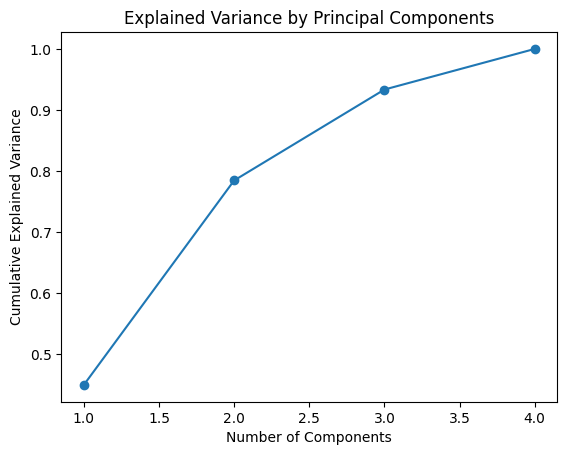

In [10]:
# Plotting explained variance
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

The PCA results indicate that the first three principal components explain about 93.35% of the variance
in the data, with the first component alone accounting for 45.01%. This suggests that we can focus on these
components to understand the key factors influencing productivity in the organization. By reducing the dataset
to these components, we simplify the analysis while still capturing most of the important information,
making it easier to identify and address the primary drivers of productivity.

<Axes: >

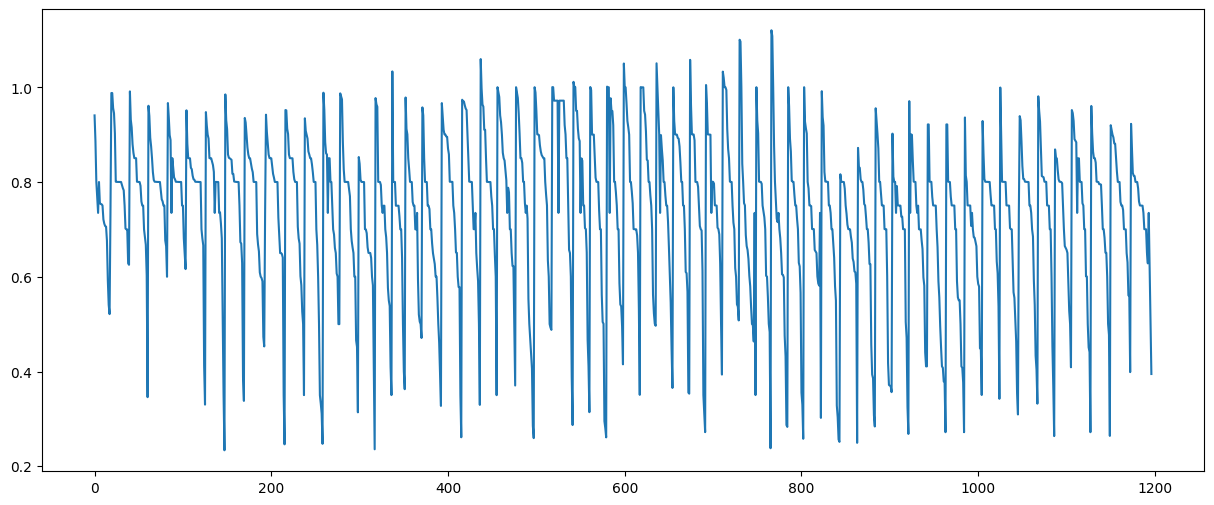

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
funnel['Actual Productivity'].plot()

**Predictive Modeling and Time Series Analysis**

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
funnel = funnel.set_index('Date')
ts = funnel['Actual Productivity']
# Splitting data for training and testing
train_data = ts[:-4]
test_data = ts[-4:]
# Fitting ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
# Forecast
forecast = model_fit.forecast(steps=4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [13]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# Calculatting MAPE
mape = mean_absolute_percentage_error(test_data, forecast)
print('MAPE:', mape)
# Calculating MSE
mse = mean_squared_error(test_data, forecast)
print('MSE:', mse)

MAPE: 0.33816528363828074
MSE: 0.03520826769803666


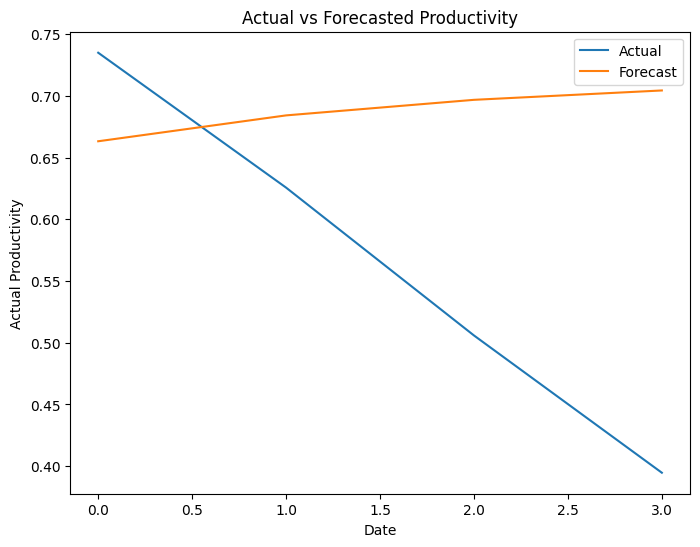

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot( test_data.values, label='Actual')
plt.plot( forecast.values, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Actual Productivity')
plt.title('Actual vs Forecasted Productivity')
plt.legend()
plt.show()

Evaluated the ARIMA model's forecasts by calculating the
Mean Absolute Percentage Error (MAPE), which was 33.8%, and the Mean Squared Error (MSE), which was 0.035.

**Clustering Analysis**

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Selecting features for clustering
features_for_clustering = ['Actual Productivity', 'Overtime', 'No. of Workers']
X_clustering = funnel[features_for_clustering]
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

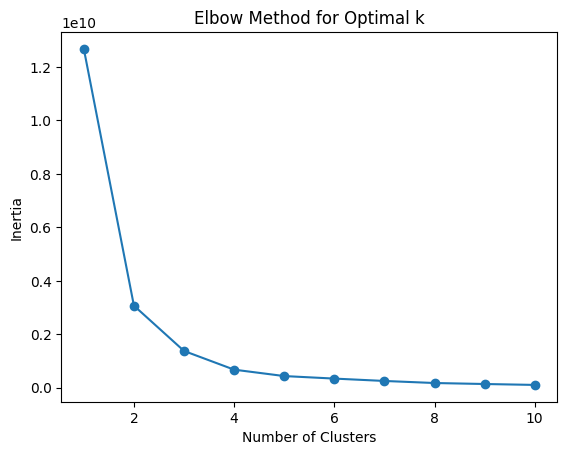

In [16]:
# Plotting the Elbow method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [17]:
#Based on the Elbow method, I determined that the optimal number of clusters is 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
funnel['Cluster'] = kmeans.fit_predict(X_clustering)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


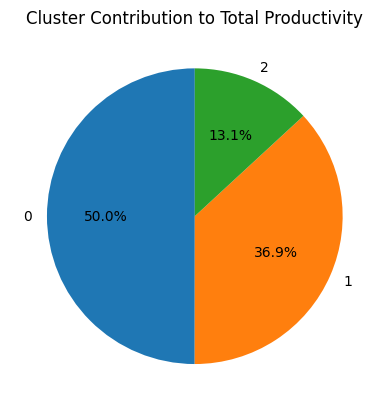

In [18]:
import matplotlib.pyplot as plt
# Summing productivity by cluster
cluster_productivity = funnel.groupby('Cluster')['Actual Productivity'].sum()
# Creating pie chart
plt.pie(cluster_productivity, labels=cluster_productivity.index, autopct='%1.1f%%', startangle=90)
plt.title('Cluster Contribution to Total Productivity')
plt.show()

In [19]:
print('cluster_productivity: ',cluster_productivity)

cluster_productivity:  Cluster
0    425.830324
1    314.110055
2    111.866932
Name: Actual Productivity, dtype: float64


The productivity data reveals that Cluster 0, with a value of 425.83, is the most productive group, likely consisting of the most efficient workers. Cluster 1, with a productivity of 314.11, represents a moderately productive segment, contributing positively but not as strongly. Lastly, Cluster 2, with a productivity of 111.87

**Budget Allocation Strategy (Bonus)**

In [20]:
department_quarterly_spend = 8.4
# Calculating Department Value for each row
funnel['Department Value'] = funnel['Actual Productivity'] / department_quarterly_spend
# Analyzing the value brought by each department
department_value_analysis = funnel.groupby('Cluster')['Department Value'].agg(['mean', 'sum'])
print(department_value_analysis)

             mean        sum
Cluster                     
0        0.088626  50.694086
1        0.085766  37.394054
2        0.086477  13.317492


In [21]:
# Calculating the productivity per lakh spent for each cluster
productivity_per_lakh = funnel.groupby('Cluster')['Actual Productivity'].sum() / department_quarterly_spend
# Normalizing the productivity per lakh to get a proportion for budget allocation
total_productivity_per_lakh = productivity_per_lakh.sum()
budget_allocation_proportions = productivity_per_lakh / total_productivity_per_lakh
# Calculating the revised budget allocation for each cluster
revised_budget_allocation = budget_allocation_proportions * department_quarterly_spend
print("Revised Budget Allocation:")
for cluster_id, allocation in revised_budget_allocation.items():
    print(f"Cluster {cluster_id}: {allocation:.2f} lakhs")


Revised Budget Allocation:
Cluster 0: 4.20 lakhs
Cluster 1: 3.10 lakhs
Cluster 2: 1.10 lakhs


The revised budget allocation strategy is based on the principle of allocating resources
proportionally to the productivity generated per unit of expenditure.
By analyzing the productivity per lakh spent for each cluster, we identified the clusters
that generate the most output for each unit of investment. The revised budget allocates a
larger share of resources to these high-performing clusters, aiming to maximize the overall
productivity.

# Section 2 - Anomaly detection

**Data Import and Exploration**

In [22]:
import pandas as pd
transactions = pd.read_excel('/content/drive/MyDrive/FittLyf Assessment/AssignmentData.xlsx',sheet_name='creditcard')
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [23]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  int64  
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  object 
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  object 
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  object 
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [24]:
for col in transactions.columns:
    # Checking if the column is of object type
    if transactions[col].dtype == 'object':
        # Converting to numeric, coercing errors to NaN
        transactions[col] = pd.to_numeric(transactions[col], errors='coerce')
        # Filling NaN values with the mean of the column
        mean_value = transactions[col].mean()
        transactions[col].fillna(mean_value, inplace=True)

In [25]:
transactions['Class'].value_counts()

,count
Class,
0,284315
1,492


In [26]:
# Calculating the percentage of fraudulent transactions
class_distribution = transactions['Class'].value_counts()
fraud_percentage = (class_distribution[1] / class_distribution.sum()) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")

Percentage of fraudulent transactions: 0.17%


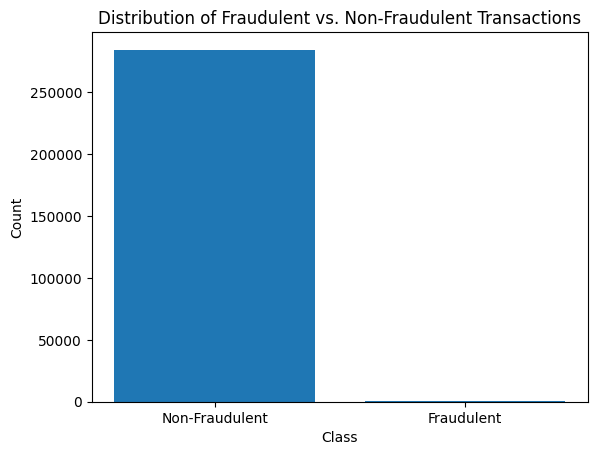

In [27]:
# Visualizing the class distribution
import matplotlib.pyplot as plt
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.show()

In [28]:
# Summary statistics for numerical features
print(transactions.describe())

                Time            V1             V2            V3            V4  \
count  284807.000000  2.848070e+05  284807.000000  2.848070e+05  2.848070e+05   
mean    94813.859575  1.156799e-15      -0.000009 -1.389117e-15  2.112416e-15   
std     47488.145955  1.958696e+00       1.651301  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01     -72.715728 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01      -0.598550 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02       0.065467  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00       0.803717  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00      22.057729  9.382558e+00  1.687534e+01   

                 V5            V6             V7            V8            V9  \
count  2.848070e+05  2.848070e+05  284807.000000  2.848070e+05  2.848070e+05   
mean   1.048624e-15  1.491305e-15       0.000004  1.159593e-16 -8.279026e-07   
std    1.380247e+00  1.332271e

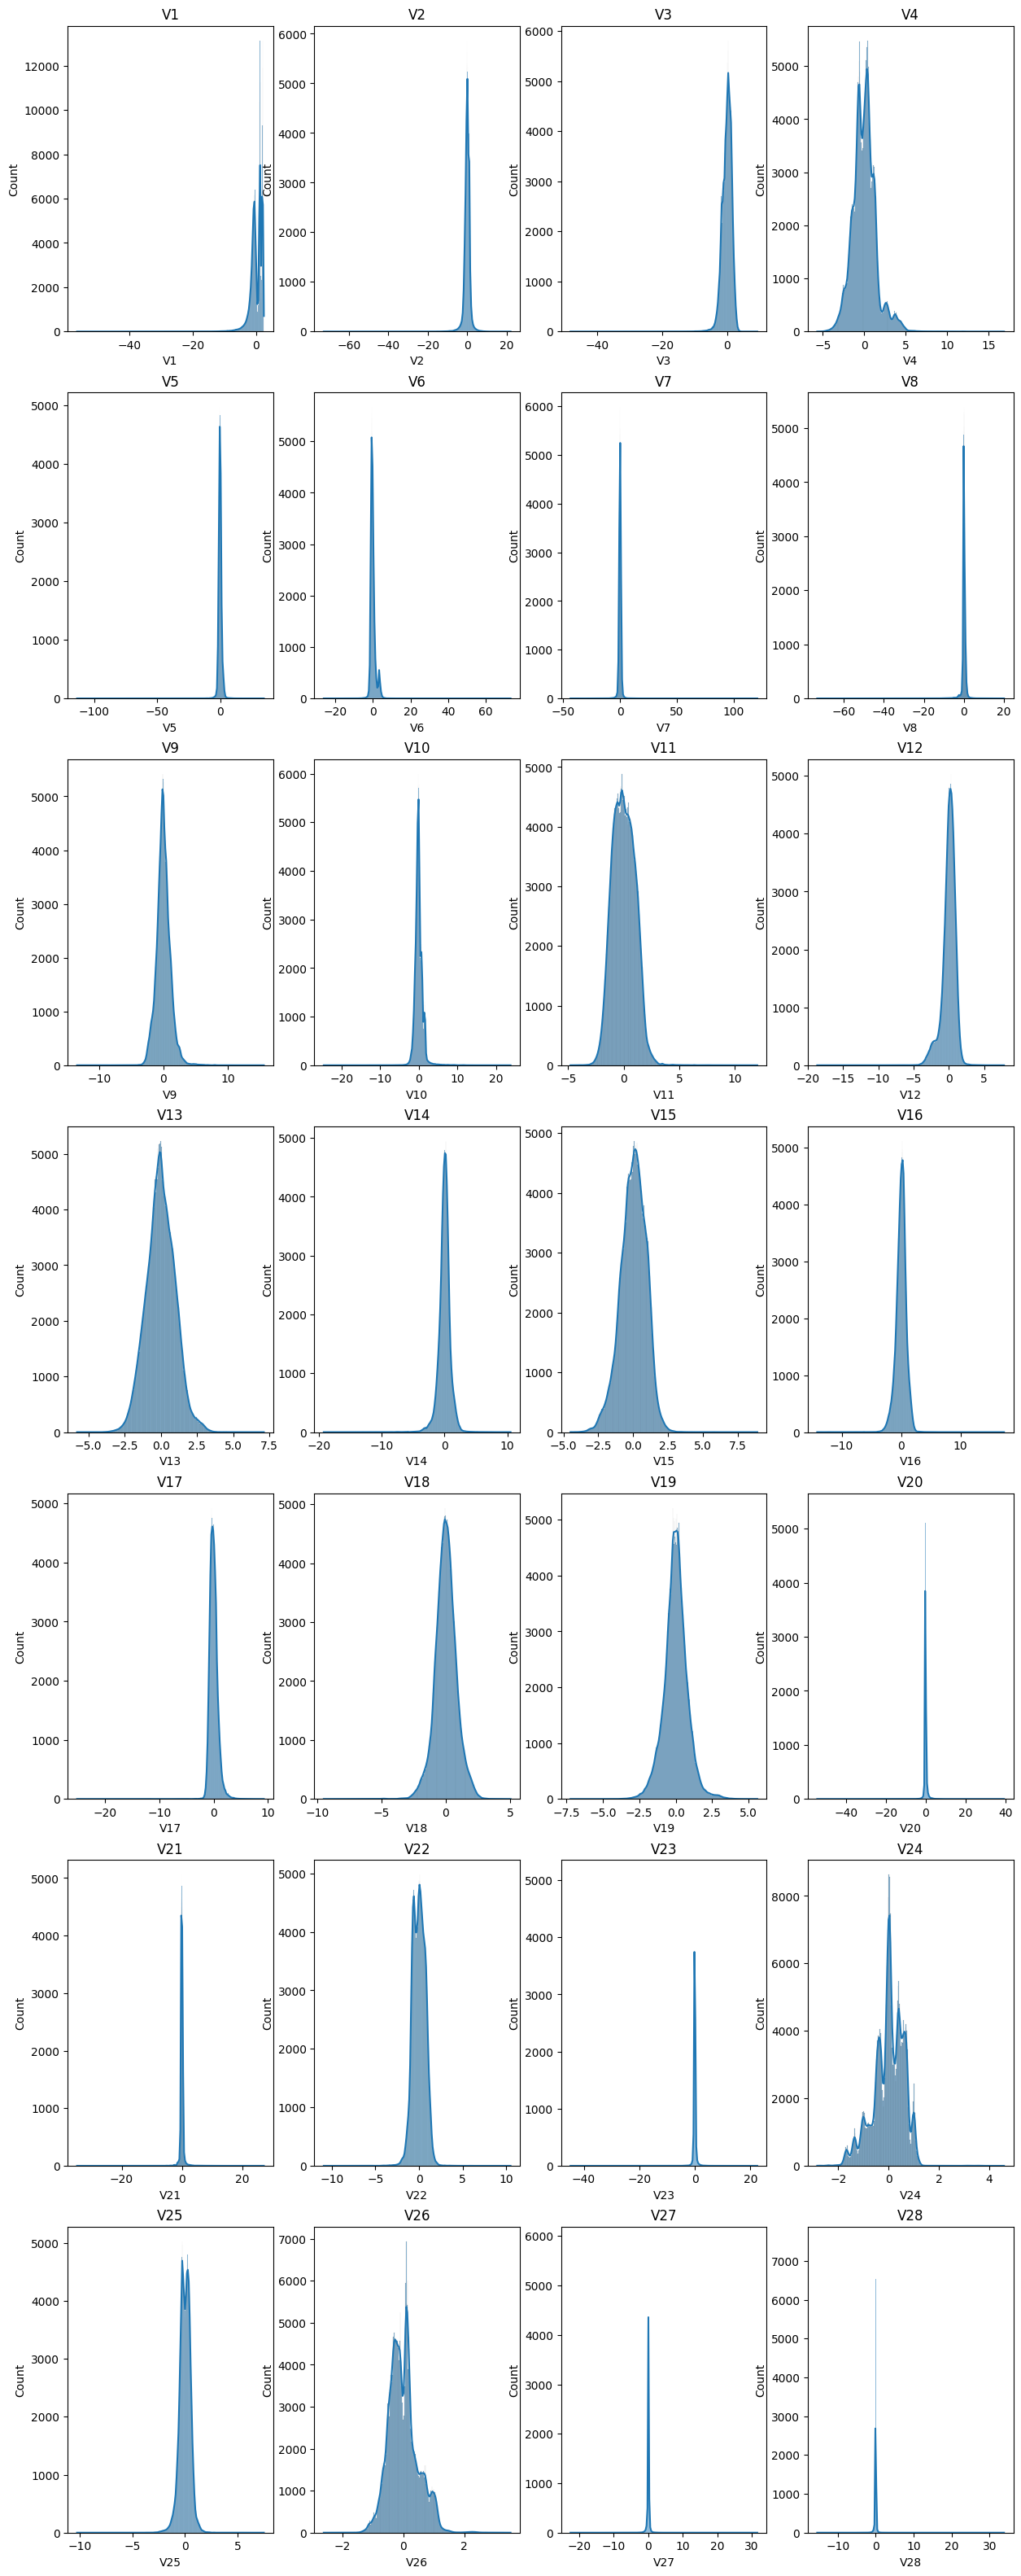

In [29]:
import seaborn as sns
plt.figure(figsize=(15,40))
for i in range(1,29):
  plt.subplot(7,4,i)
  col=transactions.columns[i]
  sns.histplot(transactions[col],kde=True)
  plt.title(col)
plt.show()


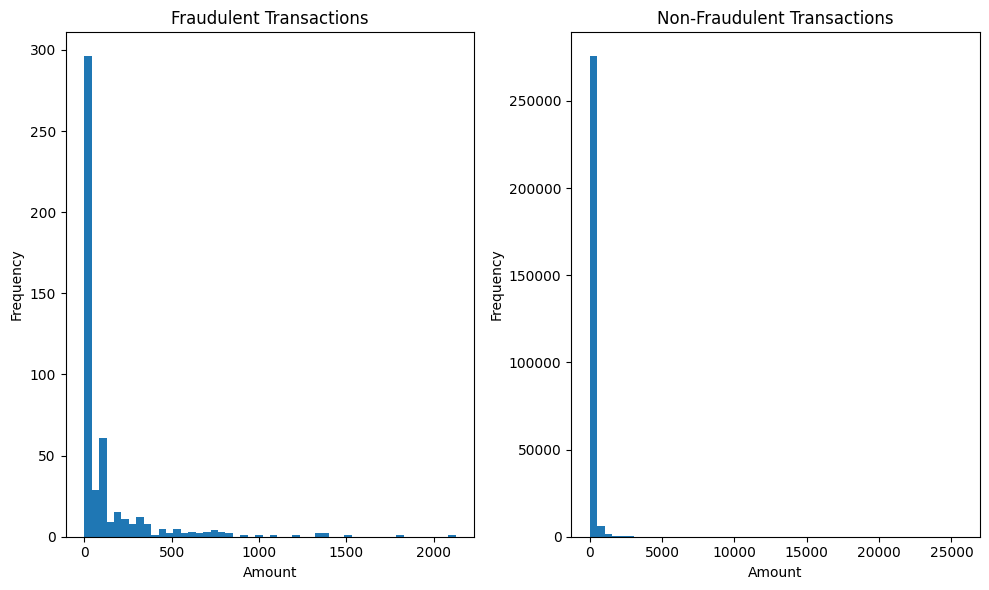

In [30]:
import matplotlib.pyplot as plt
# Creating separate DataFrames for fraudulent and non-fraudulent transactions
fraudulent = transactions[transactions['Class'] == 1]
non_fraudulent = transactions[transactions['Class'] == 0]

# Plotting histograms of transaction amounts
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(fraudulent['Amount'], bins=50)
plt.title('Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(non_fraudulent['Amount'], bins=50)
plt.title('Non-Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Feature Engineering**

In [31]:
from sklearn.preprocessing import StandardScaler
# Initializing the scaler
scaler = StandardScaler()
# Fitting and transforming the 'Amount' and 'Time' features
transactions[['Amount', 'Time']] = scaler.fit_transform(transactions[['Amount', 'Time']])

StandardScaler standardizes features by removing the mean and scaling to unit variance.
This is often preferred for machine learning algorithms that assume features are normally distributed,
such as logistic regression or support vector machines.

In the context of credit card fraud detection, the 'Amount' feature can have a wide range of values,
and 'Time' is measured in seconds and can also have a large range.
Scaling these features helps to prevent features with larger ranges from dominating the learning process
and improves the performance of many machine learning models.

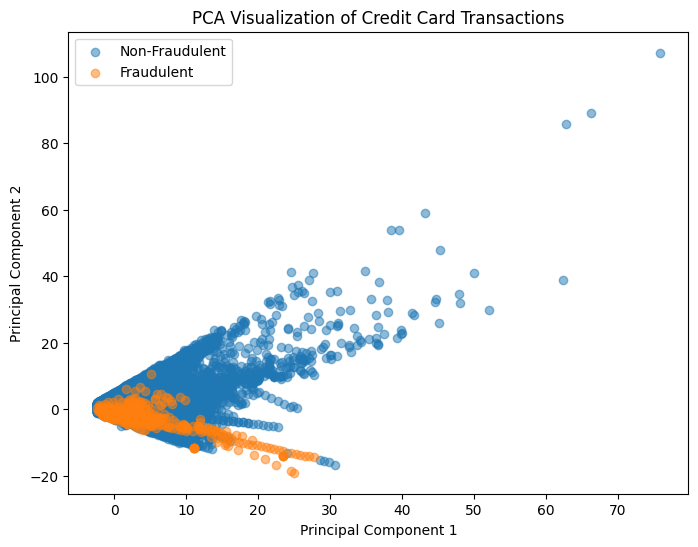

In [32]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
transactions_pca = pca.fit_transform(transactions.drop('Class', axis=1))
# Visualizing the data in two dimensions
plt.figure(figsize=(8, 6))
plt.scatter(transactions_pca[transactions['Class'] == 0, 0], transactions_pca[transactions['Class'] == 0, 1], label='Non-Fraudulent', alpha=0.5)
plt.scatter(transactions_pca[transactions['Class'] == 1, 0], transactions_pca[transactions['Class'] == 1, 1], label='Fraudulent', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Credit Card Transactions')
plt.legend()
plt.show()


**Anomaly Detection Model**

In [33]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
# Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
iso_forest.fit(transactions.drop('Class', axis=1))
iso_predictions = iso_forest.predict(transactions.drop('Class', axis=1))
# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_predictions = lof.fit_predict(transactions.drop('Class', axis=1))
# Converting predictions to binary (1 for anomaly, 0 for normal)
iso_predictions[iso_predictions == 1] = 0
iso_predictions[iso_predictions == -1] = 1
lof_predictions[lof_predictions == 1] = 0
lof_predictions[lof_predictions == -1] = 1

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# Calculating evaluation metrics for Isolation Forest
iso_precision = precision_score(transactions['Class'], iso_predictions)
iso_recall = recall_score(transactions['Class'], iso_predictions)
iso_f1 = f1_score(transactions['Class'], iso_predictions)
iso_roc_auc = roc_auc_score(transactions['Class'], iso_predictions)
# Calculating evaluation metrics for Local Outlier Factor
lof_precision = precision_score(transactions['Class'], lof_predictions)
lof_recall = recall_score(transactions['Class'], lof_predictions)
lof_f1 = f1_score(transactions['Class'], lof_predictions)
lof_roc_auc = roc_auc_score(transactions['Class'], lof_predictions)
# Printing the results
print("Isolation Forest:")
print("Precision:", iso_precision)
print("Recall:", iso_recall)
print("F1-Score:", iso_f1)
print("ROC-AUC:", iso_roc_auc)
print("\n")
print("Local Outlier Factor:")
print("Precision:", lof_precision)
print("Recall:", lof_recall)
print("F1-Score:", lof_f1)
print("ROC-AUC:", lof_roc_auc)

Isolation Forest:
Precision: 0.10179010179010178
Recall: 0.5894308943089431
F1-Score: 0.17360071834780003
ROC-AUC: 0.7902151569833584


Local Outlier Factor:
Precision: 0.005265005265005265
Recall: 0.03048780487804878
F1-Score: 0.008979347500748278
ROC-AUC: 0.5102599937462013


**Visualizing Anomalies**

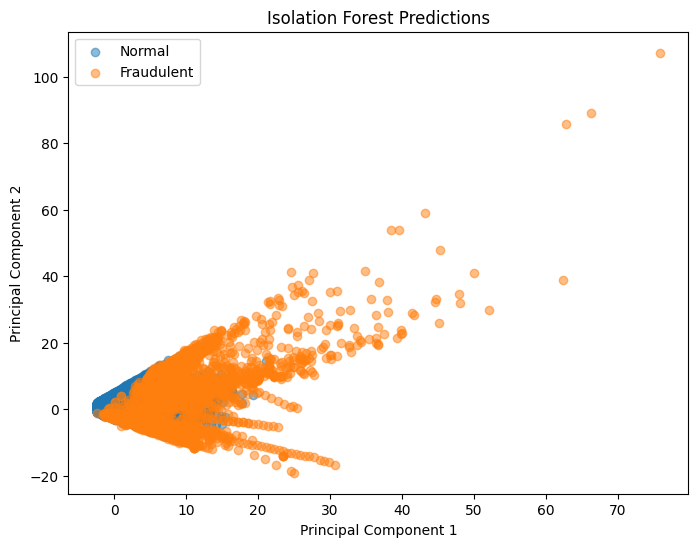

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(transactions_pca[iso_predictions == 0, 0], transactions_pca[iso_predictions == 0, 1], label='Normal', alpha=0.5)
plt.scatter(transactions_pca[iso_predictions == 1, 0], transactions_pca[iso_predictions == 1, 1], label='Fraudulent', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Isolation Forest Predictions')
plt.legend()
plt.show()


**Write a function that accepts a new dataset of credit card transactions and the trained anomaly detection model, returning a list of transactions classified as fraudulent.**

In [36]:
#function to identify fraudulent transactions
def detect_fraud(new_transactions, model):
  # Preprocessing the new transactions
  new_transactions[['Amount', 'Time']] = scaler.transform(new_transactions[['Amount', 'Time']])
  # Predicting anomalies
  predictions = model.predict(new_transactions.drop('Class', axis=1, errors='ignore'))
  # Converting predictions to binary (1 for anomaly, 0 for normal)
  predictions[predictions == 1] = 0
  predictions[predictions == -1] = 1
  # Returning indices of fraudulent transactions
  fraudulent_indices = new_transactions[predictions == 1].index.tolist()
  return fraudulent_indices


link to the site--https://app2-p3tuarxr4rgynedqf2bb2f.streamlit.app/